# GAN

 



## 1-1 GAN이란?

### 1-1-1 Vanilla GAN

이번에는 GAN(Generative Adversarial Network)이라는 생성적 적대 신경망입니다.  
가짜를 진짜처럼 만드는 모델링입니다.  
GAN의 기초가 되는 Vanilla GAN이랑 DCGAN으로 기초를 배워보고 Pix2Pix, CycleGAN으로 심화적으로 배워보겠습니다.  

In [ ]:
import tensorflow as tf # 텐서플로우 2.x 실행

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
from tqdm.notebook import tqdm #진행도 확인하는 함수

학습이 된 Gan모델에 노이즈값을 넣은 뒤 예측한 이미지를 보여주는 함수입니다.

In [ ]:
np.random.normal(0, 1, [100, 100]).shape

(100, 100)

In [ ]:
def plot_generated_images(epoch, generator):
    noise= np.random.normal(0, 1, [100, 100]) #100개의 노이즈 값을 생성합니다.
    make_images = generator.predict(noise) # 노이즈값을 통해서 GAN으로 이미지 생성합니다.
    make_images = make_images.reshape(100, 28, 28) # Mnist 사이즈와 동일하게 바꿔줍니다.
    plt.figure(figsize=(10,10)) # 이미지 크기 지정
    for i in range(make_images.shape[0]): #이미지 갯수 100만큼 반복
        plt.subplot(10, 10, i+1) #바둑판식으로 표현
        plt.imshow(make_images[i],plt.get_cmap('gray'))
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Compile에서 Adam optmizer를 호출이 가능하지만 세부조정이 어렵습니다. 
이번에는 Adam optimizer를 생성하는 함수를 만들었습니다.  
lr이라는 부분이 규제를 넣는 부분이고, beta_1, beta_2등 여러 규제를 넣을 수 가 있습니다. 

In [ ]:
def adam_optimizer() : 
  return tf.keras.optimizers.Adam(0.001) # w <- w - a*G : a = learning_rate = 0.001

Vanilla GAN 모델링에 관한 코드입니다.  
GAN은 2개의 모델이 필수적으로 사용을 하게 됩니다.  

실제이미지와 가짜 이미지를 판별해주는 Discriminator  
가짜이미지를 생성하는 Generator 모델입니다.   
모델마다 각자의 optimizer를 갖고 있으며 --> 충돌을 방지를 합니다.

데이터는 Fashion Mnist데이터를 이용하여 실습하겠습니다.

Conv1D에서 Mnist 데이터를 학습을 시켰을 때는 /255를 통하여 0~1 사이의 실수를 만들었습니다.  

GAN에서는 -127.5를 뺀후 나누게 됩니다. 이러면 데이터가 -1 ~  1사이의 값이 됩니다.



In [ ]:
epochs = 20  #반복 횟수를 정해줍니다.
batch_size = 128 #배치사이즈를 정해줍니다.

(x_train, _), (_, _) = datasets.fashion_mnist.load_data() 
x_train = (x_train.astype(np.float32)-127.5)/127.5  
x_train = x_train.reshape(60000, 784) 
batch_count = x_train.shape[0] / batch_size  #데이터의 양을 배치사이즈 크기만큼 나눠서 학습시킵니다.

4423680/4422102 [==============================] - 0s 0us/step


Generator 모델을 만듭니다.  
입력데이터는 100개의 노이즈 이며 3층으로 쌓은 FFN 입니다.  
활성함수는 ReLU를 사용하였고, 마지막에는 Tanh를 사용하였습니다.  
Tanh를 사용한 것은 데이터를 정규화 시킬 때 음수의 값을 포함하여 하였기 때문에  
생성된 값 또한 음수를 표현을 하기 위해서 Tanh를 사용하게 되었습니다. 

Binary_crossetropy를 사용하여 이진 분류를 사용하였고, optimizer는 아까 규제를 넣은 adam을 사용하였습니다. 
  
속도를 높이기 위해 Dropout을 사용하게 되었습니다. 

Generator의 최종 결과는 784이고 이는 mnist의 이미지 크기와 동일합니다.


In [ ]:
# 이미지를 만드는 부분, 
generator=models.Sequential()
generator.add(layers.Dense(256, input_dim=100, activation='relu'))
generator.add(layers.Dense(512,activation='relu'))
generator.add(layers.Dropout(0.3))
generator.add(layers.Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

discriminator 모델을 만듭니다. 
입력데이터는 minist파일의 크기이며 3층으로 쌓은 FFN 모델입니다.  
Generator와 다르게 unit의 수가 점점 줄어드는 것을 확인 할 수 있습니다.  

마지막 활성함수는 sigmoid를 사용함으로서 0 1사이에 거짓 이미지인지 실제 이미지인지를 판별을 해주는 것입니다.  

In [ ]:
discriminator=models.Sequential()
discriminator.add(layers.Dense(512,input_dim=784,activation='relu'))
discriminator.add(layers.Dense(256,activation='relu'))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

이제는 두 모델을 합칩니다.  
discriminator.trainable=Fals --> 학습을 하지만 weight값을 변경을 못하게 하는 의미를 가집니다.  
실제이미지와 가짜이미지를 판결하기 위해서 Binary_CrossEntropy를 사용하였고,  
input의 데이터는 가짜이미지이고, output은 실제인지 가짜인지 판별해주는 discriminator의 결과값입니다.  

In [ ]:
discriminator.trainable=False # weight 학습불가
gan_input = layers.Input(shape=(100,))
x = generator(gan_input)


gan_output= discriminator(x)
gan= models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

모델을 학습시키는 코드입니다. 

위에서 설정한 Epochs 수만큼 학습을 하게 되고, batch_count만큼 반복하게 됩니다.     
x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]의 코드는 

데이터의 0 ~ 데이터의 크기 중 batch_size만큼 랜덤으로 뽑는 것입니다.   
진짜 이미지와 가짜 이미지를 합친 후  
그 크기만큼의 배열을 생성한 뒤 실제 이미지에는 0.9의 값을 주고 가짜 이미지에는 0의 값을 줍니다.  
그 후 discriminator를 학습을 시킵니다.  
배치사이즈 크기만큼 배열을 생성한 뒤 값을 1로 세팅하여 gan에 노이즈값과 함께 학습을 시킵니다. 

In [ ]:
import numpy as np

np.random.randint(0,x_train.shape[0], [128, 100]).shape

(128, 100)

Epochs :  1


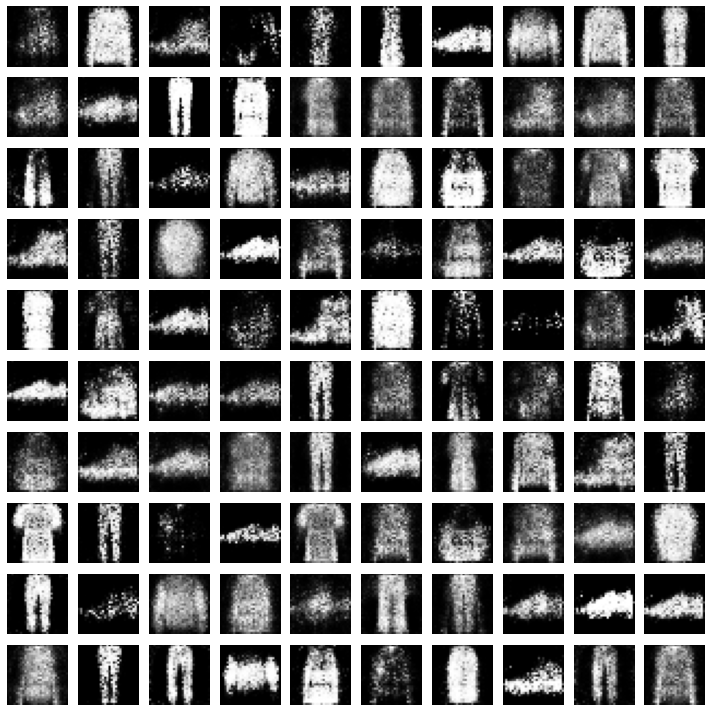

Epochs :  2
Epochs :  3
Epochs :  4
Epochs :  5
Epochs :  6
Epochs :  7
Epochs :  8
Epochs :  9
Epochs :  10
Epochs :  11
Epochs :  12
Epochs :  13
Epochs :  14
Epochs :  15
Epochs :  16
Epochs :  17
Epochs :  18
Epochs :  19
Epochs :  20


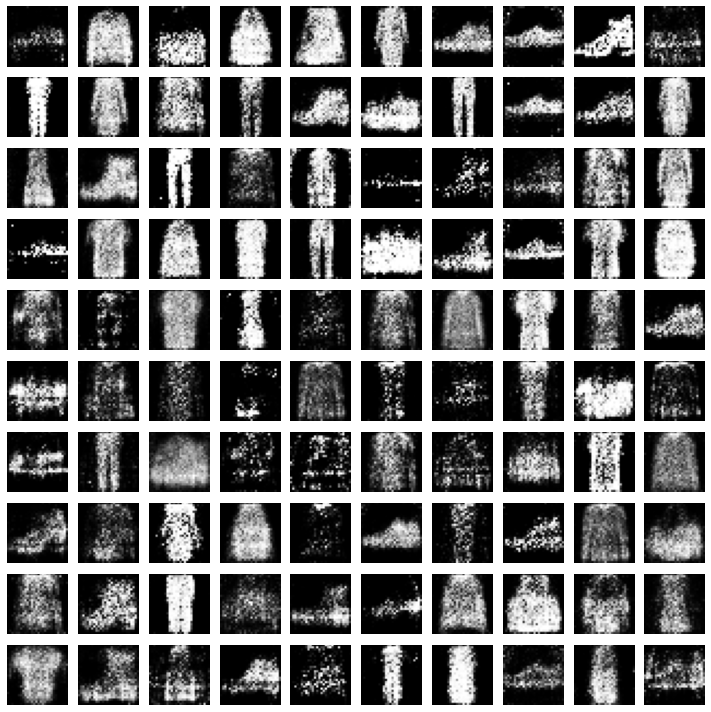

In [ ]:
for Epochs in range(1,epochs+1):
    print("Epochs : ",Epochs)
    for _ in range(int(batch_count)):
        noise = np.random.normal(0,1, [batch_size, 100]) #노이즈값 생성
        generated_images = generator.predict(noise) #노이즈 값으로 이미지 예측
        image_batch =x_train[np.random.randint(0,x_train.shape[0],batch_size)]
        

        X= np.concatenate([image_batch, generated_images])
        y_dis=np.zeros(2*batch_size) # 초기값을 0으로 주고 (batch_size*2 데이터)
        
        y_dis[:batch_size] = 0.9 # 라벨 스무딩
        y_dis[batch_size+1:] = 0.1 # 라벨 스무딩

        # y_dis [(0.5~0.10) ~ (0.9~0.95)]  ]

        #training
        discriminator.train_on_batch(X, y_dis)
        
        y_gen = np.ones(batch_size)
        gan.train_on_batch(noise, y_gen)

    if Epochs == 1 or Epochs % 20 == 0: #20번 마다 이미지 출력
        plot_generated_images(Epochs, generator)
        

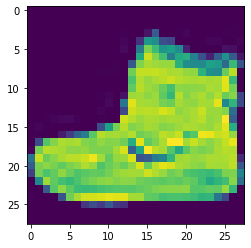

In [ ]:
(x_sample, _), (_, _) = datasets.fashion_mnist.load_data() 
plt.imshow(x_sample[0])

### 1-1-2 DCGAN

이번에는 GAN의 응용모델인 DCGAN을 설명하겠습니다.  
DCGAN은 "Deep Convolutional Generative Adversarial Nets"의 약자이며 FFN 부분을 CNN으로 바꾼 부분입니다.  
DCGAN이 탄생하게 된 것은 기존에 있던 GAN이 불안정하며 새로 만들어진 결과물들이 좋은지를 판단하기가 어렵게 되어 나오게 된 것입니다.
기존에 있던 CNN과 다른 점은 Pooling layer를 사용하지 않고 이를 strides로 교체를 한 것입니다.

Vanilla GAN을 했을 당시에는 -1 ~ 1 사이의 값으로 하였으나  
DCGAN에서는 결과가 좋지 않아 0 ~ 1 사이의 값으로 정규화를 진행하였습니다.

In [ ]:
import tensorflow as tf

In [ ]:
# 함수 선언 & 데이터 설정
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,datasets
import numpy as np
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

(x_train, y_train), (_, _) = keras.datasets.fashion_mnist.load_data() 

x_train = x_train.reshape((-1,28, 28, 1))
x_train = x_train / 255.0  

iterations = 2000 #반복횟수
batch_size = 100

Generator를 선언하는 부분입니다.  
해당 코드에서 중요한 것은 Strides 부분입니다.  
처음 보는 함수들이 있습니다.  

LeakyReLU라는 활성함수 중 하나입니다.  
Relu는 0이하인 값들은 전부 0으로 바꿔주지만 LeakyReLU는 0으로 수렴하게 해줍니다.  
Conv2DTranspose라는 Deconvolution라고 불리우고 이미지 해상도를 올리 때 사용합니다.  
Conv2D와 사용법은 동일하고 Conv2D를 거꾸로 해놓은 버전이라고 생각하시면 됩니다.
  
처음 FFN으로 통하여 이미지의 크기를 지정해줍니다.  
그 후 리사이즈를 통해 이미지가 Conv2D에 학습 할 수 있도록 바꿔줍니다. 

Conv2DTranspose에서 필터사이즈 256, 커널사이즈 4, strides 2, padding은 same으로 설정 하였습니다.  
다층 Conv2D를 지나고 Dense로 가게 되면 28  28  1 이미지의 형태가 됩니다.

Summary 부분에서 자세하게 설명하겠습니다.

In [ ]:
# 공통:
# Dense X
# Generator: DCGAN's paper:
# ==>
# 1. BatchNomalization(최적화.)
# 2. Activation은 Relu를 쓰자. (마지막엔 tanh)
# 3. PoolingX (Conv의 stride로.)


generator=models.Sequential()
# generator.add(layers.Dense(128 * 14 * 14, input_shape=(100,), activation=tf.nn.leaky_relu))
generator.add(layers.Dense(128 * 14 * 14, input_shape=(100,)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Reshape((14, 14, 128)))

generator.add(layers.Conv2D(256, 5, padding='same')) #첫 번째 Conv2D
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same')) #Deconvolution
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2D(256, 5, padding='same')) #두 번째 Conv2D
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(256, 5, padding='same')) #세 번째 Conv2D
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(1, 7, activation='tanh', padding='same')) #mnist 이미지 크기로 변환

In [ ]:
generator= models.Sequential()
# generator.add(layers.Dense(128 * 14 * 14, input_shape=(100,), activation=tf.nn.leaky_relu))
generator.add(layers.Dense(128 * 14 * 14, input_shape=(100,)))
generator.add(layers.ReLU())
generator.add(layers.Reshape((14, 14, 128)))

generator.add(layers.Conv2D(256, 5, padding='same')) #첫 번째 Conv2D
generator.add(layers.ReLU())

generator.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same')) #Deconvolution
generator.add(layers.ReLU())

generator.add(layers.Conv2D(256, 5, padding='same')) #두 번째 Conv2D
generator.add(layers.ReLU())
generator.add(layers.Conv2D(256, 5, padding='same')) #세 번째 Conv2D
generator.add(layers.ReLU())
generator.add(layers.Conv2D(1, 7, activation='tanh', padding='same')) #mnist 이미지 크기로 변환

Summary를 살펴 보게 되면  
첫 Conv2D를 지나게 되면 14 * 14 * 256의 이미지 형태가 됩니다.  
Conv2DTranspose 부분에서 지나게 되면서 28 * 28 * 256 형태로 바뀌게 됩니다.  
이는 strides부분이 기존에 있던 크기를 확장시키게 됩니다. 
strides가 3이면 이미지는 42 * 42 * 256 형태가 되는 것입니다.  
padding을 설정하게 됨으로써 strides 부분만 영향을 주게 되는 것입니다. 

위에 코드에서 strides와 padding을 조정하고 summary를 출력을 해보면 이해하기 쉬울 것입니다.

In [ ]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 25088)             2533888   
_________________________________________________________________
re_lu (ReLU)                 (None, 25088)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 256)       819456    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 256)       1048832   
_________________________________________________________________
re_lu_2 (ReLU)               (None, 28, 28, 256)      

Discriminator는 FFN 부분이 Conv2D로 바뀐 말고는 달라진 점은 없습니다. 

Conv2D 코드를 보면 strides 부분이 추가가 되어있으며 Polling 부분이 없는 것이 확인 됩니다.  

Adam이 아닌 RMSprop으로 진행하였습니다.  

In [ ]:
# Activation: 
# 1. LeakyReLU를 쓰자

discriminator = models.Sequential()
discriminator.add(layers.Conv2D(128, 3,input_shape=[28,28,1]))
discriminator.add(layers.LeakyReLU())
# discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())
# discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Flatten())
# discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Dense(1, activation='sigmoid'))

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Summary를 살펴보면 Padding이 설정되지 않기 대문에 커널 사이즈의 영향을 받아 이미지 크기가 줄어 들었습니다.  
또한 strides 부분이 2로 설정 되어있있기에 이미지의 2번 째 Conv2D 부터는 이미지 크기가 줄어드는 게 보입니다.

In [ ]:
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 128)       1280      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 128)       262272    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 5, 5, 128)         262272    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 1, 128)        

2개의 모델을 선언하고 complile을 하고 있습니다.

In [ ]:
discriminator.trainable = False

gan_input = keras.Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

Vanilla GAN에서 크게 변화 된점은 없습니다.  
한가지 있다면 원래는 실제 이미지에 label smoothing 때문에 0.9를 대입하였습니다.  
DCGAN에서는 모든 값에 0.05를 곱하여 전체에 노이즈 값을 추가하게 되었습니다.

In [ ]:
for Epochs in range(iterations):
    if (Epochs+1) % 100 == 0 : print("Epoach : ",Epochs+1)
    noise = np.random.normal(0,1, [batch_size, 100])
    generated_images = generator.predict(noise)

    real_images = x_train[np.random.randint(0,x_train.shape[0],batch_size)]
    images = np.concatenate([generated_images, real_images])
    y_dis=np.zeros(2*batch_size)
    y_dis[:batch_size]=0.9 
    
    discriminator.train_on_batch(images, y_dis)

    random_latent_vectors = np.random.normal(size=(batch_size, 100))

    y_gen = np.zeros((batch_size, 1))

    gan.train_on_batch(random_latent_vectors, y_gen)

    if Epochs % 100 == 0:
        generated_images = generated_images.reshape(100,28,28)
        plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
          
          plt.subplot(10, 10, i+1)
          plt.imshow(generated_images[i], interpolation='nearest')
          plt.axis('off')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# DCGAN's PAPER
# https://arxiv.org/pdf/1511.06434.pdf

### 1-1-3 GAN 문제 1

In [ ]:
def adam_optimizer() : 
  return tf.keras.optimizers.Adam(0.001) 

epochs = 20 
batch_size = 128 

(x_train, y_train), (_, _) = datasets.fashion_mnist.load_data() 
x_train = (x_train.astype(np.float32)-127.5)/127.5  
x_train = x_train.reshape(60000, 784) 
batch_count = x_train.shape[0] / batch_size 

generator=models.Sequential()
generator.add(layers.Dense(256,input_dim=100,activation='relu'))
generator.add(layers.Dense(512,activation='relu'))
generator.add(layers.Dropout(0.3))
generator.add(layers.Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

discriminator=models.Sequential()

#### 문제 1 ####
discriminator.add() # mnist와 가짜 이미지 생성하는 판별자의 FFN
discriminator.add() # 한층을 더 쌓는 FFN
discriminator.add() #드랍아웃 설정
################

discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

discriminator.trainable=False 
gan_input = layers.Input(shape=(100,))

#### 문제 2 ####
x = generator() # generator의 input 
gan_output= discriminator() # discriminator의 input
################

gan= models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

for Epochs in range(1,epochs+1):
    for _ in range(int(batch_count)):
        noise = np.random.normal(0,1, [batch_size, 100]) 
        generated_images = generator.predict(noise) 
        image_batch =x_train[np.random.randint(0,x_train.shape[0],batch_size)]
        X= np.concatenate([image_batch, generated_images]) 

        #### 문제 3 ####
        y_dis # discriminator 학습을 위한 y 값 생성
        y_dis # 라벨스무딩
        ################

        discriminator.train_on_batch(X, y_dis)
        y_gen = np.ones(batch_size)
        gan.train_on_batch(noise, y_gen)
    
    if Epochs == 1 or Epochs % 20 == 0: 
        make_images = generated_images.reshape(100,28,28) 
        plt.figure(figsize=(10,10))
        for i in range(make_images.shape[0]): 
          plt.subplot(10, 10, i+1)
          plt.imshow(make_images[i], interpolation='nearest')
          plt.axis('off')
        

#### ANSWER

In [ ]:
def adam_optimizer() : 
  return tf.keras.optimizers.Adam(0.001) 

epochs = 20 
batch_size = 128 

(x_train, y_train), (_, _) = datasets.fashion_mnist.load_data() 
x_train = (x_train.astype(np.float32)-127.5)/127.5  
x_train = x_train.reshape(60000, 784) 
batch_count = x_train.shape[0] / batch_size 

generator=models.Sequential()
generator.add(layers.Dense(256,input_dim=100,activation='relu'))
generator.add(layers.Dense(512,activation='relu'))
generator.add(layers.Dropout(0.3))
generator.add(layers.Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

discriminator=models.Sequential()

#### 정답 1 ####
discriminator.add(layers.Dense(784,input_dim=784,activation='relu'))
discriminator.add(layers.Dense(256,activation='relu'))
discriminator.add(layers.Dropout(0.3))
################

discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

discriminator.trainable=False 
gan_input = layers.Input(shape=(100,))

#### 정답 2 ####
x = generator(gan_input)
gan_output= discriminator(x)
################

gan= models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

for Epochs in range(1,epochs+1):
    print("Epochs : ",Epochs)
    Dloss_data,Gloss_data =0,0
    for _ in range(int(batch_count)):
        noise = np.random.normal(0,1, [batch_size, 100]) 
        generated_images = generator.predict(noise) 
        image_batch =x_train[np.random.randint(0,x_train.shape[0],batch_size)]
        X= np.concatenate([image_batch, generated_images])

        #### 정답 3 #####
        y_dis=np.zeros(2*batch_size)
        y_dis[:batch_size]=0.9 
        #################

        discriminator.train_on_batch(X, y_dis)
        y_gen = np.ones(batch_size)
        gan.train_on_batch(noise, y_gen)
    
    if Epochs == 1 or Epochs % 20 == 0: 
      noise= np.random.normal(0, 1, [100, 100]) #100개의 노이즈 값을 생성합니다.
      make_images = generator.predict(noise)
      make_images = make_images.reshape(100,28,28) 
      plt.figure(figsize=(10,10))
      for i in range(make_images.shape[0]): 
        plt.subplot(10, 10, i+1)
        plt.imshow(make_images[i], interpolation='nearest')
        plt.axis('off')
        

### 1-1-4 GAN 문제 2

In [ ]:
(x_train, y_train), (_, _) = keras.datasets.fashion_mnist.load_data() 

x_train = x_train.reshape((-1,28, 28, 1))
x_train = x_train / 255.0  

iterations = 2000 
batch_size = 100

generator=models.Sequential()
generator.add(layers.Dense(128 * 14 * 14, input_shape=(100,)))
generator.add(layers.LeakyReLU())
generator.add(layers.Reshape((14, 14, 128)))
generator.add(layers.Conv2D(256, 5, padding='same'))
generator.add(layers.LeakyReLU())

#### 문제 1 ####
generator.add() #이미지 업스케일링 하기
################

generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(256, 5, padding='same')) 
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(256, 5, padding='same'))
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(1, 7, activation='tanh', padding='same')) 



discriminator=models.Sequential()
discriminator.add(layers.Conv2D(128, 3,input_shape=[28,28,1]))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())

#### 문제 2 ####
discriminator.add() # 3차원 -> 2차원 축소
discriminator.add() # 드랍아웃 
discriminator.add() # unit 1인 FFN
################

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

discriminator.trainable = False

gan_input = keras.Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004,clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')


for Epochs in range(iterations):
    if (Epochs+1) % 100 == 0 : print("Epoach : ",Epochs+1)
    noise = np.random.normal(0,1, [batch_size, 100])
    generated_images = generator.predict(noise)

    real_images = x_train[np.random.randint(0,x_train.shape[0],batch_size)]
    images = np.concatenate([generated_images, real_images])
    y_dis=np.zeros(2*batch_size)
    y_dis[:batch_size]=0.9 
    
    #### 문제 3 ####
    discriminator # discriminator 학습
    ################

    random_latent_vectors = np.random.normal(size=(batch_size, 100))

    y_gen = np.zeros((batch_size, 1))

    #### 문제 4 ####
    gan #generator 학습
    ################

    if Epochs % 100 == 0:
        generated_images = generated_images.reshape(100,28,28)
        plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
          
          plt.subplot(10, 10, i+1)
          plt.imshow(generated_images[i], interpolation='nearest')
          plt.axis('off')


#### ANSWER

In [ ]:
(x_train, y_train), (_, _) = keras.datasets.fashion_mnist.load_data() 

x_train = x_train.reshape((-1,28, 28, 1))
x_train = x_train / 255.0  

iterations = 2000 
batch_size = 100

generator=models.Sequential()
generator.add(layers.Dense(128 * 14 * 14, input_shape=(100,)))
generator.add(layers.LeakyReLU())
generator.add(layers.Reshape((14, 14, 128)))
generator.add(layers.Conv2D(256, 5, padding='same'))
generator.add(layers.LeakyReLU())

#### 정답 1 ####
generator.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same')) 
################

generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(256, 5, padding='same')) 
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(256, 5, padding='same')) 
generator.add(layers.LeakyReLU())
generator.add(layers.Conv2D(1, 7, activation='tanh', padding='same')) 



discriminator=models.Sequential()
discriminator.add(layers.Conv2D(128, 3,input_shape=[28,28,1]))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU())

#### 정답 2 ####
discriminator.add(layers.Flatten())
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Dense(1, activation='sigmoid'))
#################

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

discriminator.trainable = False

gan_input = keras.Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004,clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')


for Epochs in range(iterations):
    if (Epochs+1) % 100 == 0 : print("Epoach : ",Epochs+1)
    noise = np.random.normal(0,1, [batch_size, 100])
    generated_images = generator.predict(noise)

    real_images = x_train[np.random.randint(0,x_train.shape[0],batch_size)]
    images = np.concatenate([generated_images, real_images])
    y_dis=np.zeros(2*batch_size)
    y_dis[:batch_size]=0.9 
    
    #### 정답 3 ####
    discriminator.train_on_batch(images, y_dis)
    ################

    random_latent_vectors = np.random.normal(size=(batch_size, 100))

    y_gen = np.zeros((batch_size, 1))

    #### 정답 4 ####
    gan.train_on_batch(random_latent_vectors, y_gen)
    ################

    if Epochs % 100 == 0:
        generated_images = generated_images.reshape(100,28,28)
        plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
          
          plt.subplot(10, 10, i+1)
          plt.imshow(generated_images[i], interpolation='nearest')
          plt.axis('off')


### 1-1-5 GAN 문제 3

In [ ]:
try:
  %tensorflow_version 2.x"
except Exception:
  pass
import tensorflow as tf #텐서플로우 2.x 실행

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,datasets
import numpy as np
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

#### ANSWER

## 2-1 GAN의 종류

### 2-1-1 Pix2PIX

GAN의 응용모델인 Pix2Pix 입니다.  
이미지를 주면 그려주는 GAN 모델입니다.    
GAN은 Loss그래프가 일정하지 못하기 때문에 그릴 수가 없었습니다.  
하지만 해당 모델은 Norm1과 결합하여 Loss그래프를 그릴 수 있습니다.   

코드는 Tensorflow 공홈에 있는 코드로 설명 드리겠습니다.  
출처 : https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko  

Pix2Pix 체험 : https://affinelayer.com/pixsrv/




In [ ]:

import tensorflow as tf #텐서플로우 2.x 실행

In [ ]:
# 함수선언
import tensorflow as tf

from tensorflow.keras import layers,Model,Sequential,Input
import os
import time

from matplotlib import pyplot as plt
from IPython import display

#데이터 설정
BUFFER_SIZE = 400 #Train 데이터셋 갯수
BATCH_SIZE = 1 
IMG_WIDTH = 256 #이미지의 넓이
IMG_HEIGHT = 256 #이미지의 높이
EPOCHS = 30 #에폭

데이터셋은 pix2pix에 맞는 데이터셋을 불러오겠습니다.

In [ ]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',origin=_URL,extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/') #경로 지정

모델링을 하기에 앞서 이미지 처리 함수와 데이터셋이 어떻게 되어 있는질를 확인하겠습니다.  


데이터의 이미지의 크기는 256 x 512 x 3의 크기를 가진 데이터셋 입니다.  
  이미지를 256 x 256 x 256 형태로 바꾸고 타입(Type)을 float32로 바꿉니다.

이미지 데이터 셋을 보게 되면 Real_image, input_image 라는 것을 확인 할 수가 있습니다. 

In [ ]:
def load(image_file): 
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  w = tf.shape(image)[1] #shape (256,512,3)

  w = w // 2 
  real_image = image[:, :w, :] # shape (256,256,3)
  input_image = image[:, w:, :] # shaep (256,256,3)

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  
  return input_image, real_image

이미지의 크기를 조정하는 함수입니다.  

In [ ]:
def resize(input_image, real_image, height, width): 
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

이미지의 임의의 부분을 잘라 크기를 맞춰주는 함수입니다.

In [ ]:
def random_crop(input_image, real_image): 
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

이미지 데이터 셋을 -1 ~ 1의 값으로 정규화 해주는 함수입니다.

In [ ]:
def normalize(input_image, real_image): 
  input_image = (input_image / 127.5) - 1 # -1 ~ 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

이미지를 랜덤으로 처리하여 입력데이터를 가공하는 함수입니다.  
처음 256 x 256 x 3 이미지를 리사이징을 시켜 286 x 286 x 3의 형태를 바꿉니다.   
리사이징한 이미지를 다시 256 x 256 x 3으로 바꿔주기 위해 랜덤 부분을 커팅하여   
  이미지의 크기를 줄여 256 x 256 x 3 형태로 바꿉니다.

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # 리사이즈 256 x 256 x 3 --> 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # 랜덤 이미지 자르기 286 x 286 x 3 --> 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)
  
  # 상하 좌우로 이미지를 바꿉니다.
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image) #좌우 회전
    real_image = tf.image.flip_left_right(real_image) #상하 회전
  return input_image, real_image

이미지가 어떻게 바뀌는지를 확인을 해보겠습니다. 

Train데이터셋의 100이라는 데이터로 보겠습니다.  
그 중 real_image가 아닌 input_image로 보겠습니다   
한 개의 데이터로 random_jitter를 호출시켜 확인 했을 때  
이미지가 서로 다른 것을 확인 할 수가 있습니다.  

In [ ]:
inp, re = load(PATH+'train/100.jpg')

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255)
  plt.axis('off')
plt.show()

이번에는 real_image를 살펴 보겠습니다.  
건물의 실제 이미지를 확인 할 수가 있습니다.  

input데이터를 입력데이터로 학습을 시켜 real_image와 비슷하게 뽑는 것이 Pix2Pix 모델링의 모습입니다 .

In [ ]:
plt.imshow(rj_re/255)
plt.axis('off')
plt.show()


출처 : https://m.blog.naver.com/PostView.nhn?blogId=laonple&logNo=221366130381&proxyReferer=https%3A%2F%2Fwww.google.com%2F


Pix2Pix 모델을 짜게 되면 위에 이미지와 같으 형태가 됩니다.  
U-net구조와 patchGAN에 대해서 간단히 설명하겠습니다.  
  

U-net은 모델링의 모습이 U모양과 같습니다.  
이미지를 Downsampling을 하여 최대 줄인 다음 Upsampling을 통하여 원래 이미지의 형태로 만드는 것입니다.  
각 크기에 맞춰 대응시키는 것도 중요합니다.  

PatchGAN은 입력 데이터 2개를 Concat을 시켜 하나의 데이터셋으로 Downsampling을 하는 것입니다.  
그래서 input_image와 real_image를 학습을 시켜 비교를 하는 것입니다.  

load_image_train 함수는 위에 데이터셋을 확인 할 때 사용했던 함수들을 이용하여
데이터셋을 구축하는 것입니다 

In [ ]:
def load_image_train(image_file): #Train 데이터셋 설정
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file): #Test 데이터셋 설정
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

데이터 셋을 구축하겠습니다.   
이번에는 400의 데이터 셋을 학습하기에 알맞게 정규화 하는 작업입니다.  
 
num_parallel_calls=tf.data.experimental.AUTOTUN --> CPU를 최대로 사용

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

Downsampling이 많이 호출이 되어 함수로 선언 된 모습입니다.  

initializer : 변수나 상수의 초기화 시켜주니다.  

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02) #초기화 설정

  result = Sequential() #모델 선언
  result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                    kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm: #배치정규화 함수
    result.add(layers.BatchNormalization())

  result.add(layers.LeakyReLU()) #LeakyReLU

  return result

Upsampling도 많이 호출 되기에 함수로 선언된 모습입니다.  
다운샘플링과 다르게 DeConverlution을 사용하여 이미지의 크기를 늘립니다. 

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(layers.Conv2DTranspose(filters, size, strides=2,padding='same',
                              kernel_initializer=initializer,use_bias=False))

  result.add(layers.BatchNormalization())

  if apply_dropout: result.add(layers.Dropout(0.5))

  result.add(layers.ReLU())

  return result

Generator 함수를 선언하겠습니다.  
위에 설명하듯이 U-net구조를 사용을 하여 각 8층을 쌓은 것을 확인 할 수 가 있습니다.  

업샘플링 같은 경우에는 따로 선언을 하였는데 이는 활성함수가 ReLU가 아닌 Tanh이기 때문에 선언을 따로 한 모습입니다.   

다운샘플링을 쌓으면서 마지막에는 Reverse로 역전하는 모습을 볼 수 있는데  
이는 업샘플링과 같은 크기로 1:1 매칭을 하기 위해서 입니다. 

In [ ]:
def Generator(): #UNET 구조 CNN
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  #다운샘플링
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  #업샘플링
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02) #초기화
  #업샘플링 
  last = layers.Conv2DTranspose(3, 4,strides=2, padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

# 다운샘플링 진행
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  
  #역순
  skips = reversed(skips[:-1])

#업 샘플링 진행
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = layers.Concatenate()([x, skip])

  x = last(x)

  return Model(inputs=inputs, outputs=x)

Discriminator 모델입니다.  
2개의 입력데이터를 Concat을 시킵니다.  
256 x 256 x 3이 아닌 256 x 256 x 6 의 모습을 하게 됩니다.  

다운샘플링을 통해서 이미지의 크기를 줄여주고  
ZeroPadding을 사용하여 0의 값으로 Padding을 시킵니다.  

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = Input(shape=[256, 256, 3], name='input_image')
  tar = Input(shape=[256, 256, 3], name='target_image')

  x = layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = layers.BatchNormalization()(conv)
  leaky_relu = layers.LeakyReLU()(batchnorm1)
  zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return Model(inputs=[inp, tar], outputs=last)

모델을 선언합니다

In [ ]:
generator = Generator()
discriminator = Discriminator()
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Generator loss 선언하는 함수입니다.  
제너레이터는 로스가 3개의 모습을 확인 할 수 있습니다.  
일반적인 Generator로스와 Norm1의 로스, 두개를 합친 로스 입니다. 

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output)) #Mean absolute error
  total_gen_loss = gan_loss + (100 * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

discriminator loss 선언하는 함수입니다.   
제너레이터 로스와 다르게 2개의 이미지 로스를 뽑은 다음  
하나의 로스로 합칩니다. 

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

Optimizer는 Adam으로 선언을 합니다.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Generator로 예측한 이미지를 표현하는 함수입니다.

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

학습시키는 함수입니다. 

위에서 배웠던 GAN과 다른 모습을 보이고 있습니다.  
Generator가 랜덤 노이즈값으로 학습하는 것이 아닌 input 데이터를 학습을 시킵니다.   
Discriminator는 2번을 학습을 하는 모습을 보입니다.  
 처음에는 원래 데이터로 학습을 하였고, 두 번째는 Generator로 생성된 이미지로 학습을 합니다. 

 tf.GradientTape()라는 함수는 그레디언트 그래프를 직접 만드는 함수입니다.  
 그래서 학습 하고 loss를 이용하여 그레디언트 그래프가 그려지게 됩니다.   
 만들어진 그래디언트 그래프를 통해서 optimizer에 추가를 하게 됩니다.

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #generator 학습시키면서 출력
    gen_output = generator(input_image, training=True)
    
    #discriminator 학습
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    
    #loss 뽑기
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)


  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

학습을 하면서 진행상태와 예측된 이미지를 보여주는 함수입니다.  
진행을 하면서 train_step 함수를 호출하여 학습을 합니다.

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
fit(train_dataset, EPOCHS, test_dataset)

랜덤한 테스트 데이터 5개로 예측 모델을 보여줍니다. 

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)


https://taeoh-kim.github.io/blog/gan%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-image-to-image-translation-pix2pix-cyclegan-discogan/

https://m.blog.naver.com/PostView.nhn?blogId=laonple&logNo=221366130381&proxyReferer=https%3A%2F%2Fwww.google.com%2F

### 2-1-2 CycleGAN

CycleGAN은 이미지를 변환시키는 모델입니다.  
사과를 오렌지로, 오렌지를 사과를 바꾸는 것처럼 실제 이미지 2개를 학습을 시켜  
이미지가 다른 형태로 만드는 모델입니다.  
GAN들은 짝을 이뤄서 학습을 시켰지만 CycleGAN은 짝을 이루지 않는 Unpaired 구조를 띕니다.  
코드는 Tensorflow2.0 홈페이지에 있는 코드입니다.  

![대체 텍스트](https://keraskorea.github.io//images/media/74_2.png)


                                        (CycleGAN의 구조)





In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf #텐서플로우 2.x 실행

In [ ]:
import tensorflow_datasets as tfds #Tensorflow 데이터셋
from tensorflow.keras import layers,models
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

Tensorflow dataset에서 CycleGAN 데이터 중 말과 얼룩말 데이터를 가져옵니다

In [ ]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [ ]:
BUFFER_SIZE = 1000 #버퍼사이즈
BATCH_SIZE = 1 #배치사이즈
IMG_WIDTH = 256 #이미지 넓이
IMG_HEIGHT = 256 #이미지 노피
EPOCHS = 15 #에폭
LAMBDA = 10 #Cycle-consistency 로스 값

Pix2Pix에서 사용했던 이미지를 랜덤한 부분을 자르는 함수입니다. 

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

노멀라이징을 합니다. 

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32) #조건에 맞게 1,0으로 반환
  image = (image / 127.5) - 1
  return image

원래 크기였던 이미지를 256x256을 286x286으로 바꾼후   
위에서 정의했던 Crop 함수를 이용하여 랜덤한 부분을 자른 뒤  
랜덤하게 이미지를 좌우반전을 합니다.  

In [ ]:
def random_jitter(image):
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  image = random_crop(image)

  image = tf.image.random_flip_left_right(image)

  return image

Train 데이터셋과 Test 데이터셋을 이미지를 프리프로세서를 진행합니다.  

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

데이터셋을 map 함수를 이용하여 프리프로세서를 진행하고 버퍼사이즈 만큼 쪼개어 셔플을 합니다.  

In [ ]:
train_horses = train_horses.map( #map 지정함수로 바꾼다.
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

프리프로세서 처리된 이미지 확인

In [ ]:
sample_horse = next(iter(train_horses)) #next -> 다음값 출력 // iter -> 반복
sample_zebra = next(iter(train_zebras))

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

In [ ]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

CycleGAN으로 넘어오면서 인스턴스노멀라이제이션(InstanceNormalization)을 쓰게 됩니다.  

기존에 썼던 배치노멀라이제이션은 하나의 면으로 노멀라이제이션을 했다면  
인스턴서노머라이제이션은 하나의 행으로 노멀라이제이션을 합니다.  

![대체 텍스트](https://i1.wp.com/mlexplained.com/wp-content/uploads/2018/11/Screen-Shot-2018-11-28-at-4.56.06-PM.png?w=522&ssl=1)

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

Pix2Pix에서 사용했던 downsample, upsample, Generator, Discriminator를 가져와서 해보겠습니다.  

다운샘플(downsample)과 업샘플(upsample)에서는 기존에 썼던 배치노말라이제이션을 인스턴스노말라이제이션으로 변경을 하였습니다. 

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02) #초기화 설정

  result = models.Sequential() #모델 선언
  result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                    kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm: #인스턴스 정규화 함수
    result.add(InstanceNormalization())

  result.add(layers.LeakyReLU()) #LeakyReLU

  return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = models.Sequential()
  result.add(layers.Conv2DTranspose(filters, size, strides=2,padding='same',
                              kernel_initializer=initializer,use_bias=False))

  result.add(InstanceNormalization())

  if apply_dropout:
      result.add(layers.Dropout(0.5))

  result.add(layers.ReLU())

  return result

Generator 함수입니다.  
바뀐 것은 따로 없습니다.  

In [ ]:
def Generator(): #UNET 구조 CNN

  inputs = tf.keras.layers.Input(shape=[256,256,3])

  #다운샘플링
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  #업샘플링
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02) #초기화
  
  #업샘플링 
  last = layers.Conv2DTranspose(3, 4,strides=2, padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

# 다운샘플링 진행
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  
  #역순
  skips = reversed(skips[:-1])

#업 샘플링 진행
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = layers.Concatenate()([x, skip])

  x = last(x)

  return models.Model(inputs=inputs, outputs=x)

Discriminator은 target이 들어가지 않아 입력을 1개로만 처리합니다.  
Batchnorm --> InstanceNorm으로 바뀝니다.  

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = layers.Input(shape=[256, 256, 3], name='input_image')

  down1 = downsample(64, 4, False)(inp) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  instancenorm1 = InstanceNormalization()(conv)
  leaky_relu = layers.LeakyReLU()(instancenorm1)
  zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return models.Model(inputs=inp, outputs=last)

Generator 함수와 discriminator 함수를 정의를 합니다.  
2개씩 선언을 하는데 이는 g모델에서 나온 Fake이미지를 X에 학습을 하고 f모델에서 나온 Fake이미지를 y로 학습을 시키기에 선언하였습니다.  

In [ ]:
generator_g = Generator()
generator_f = Generator()

discriminator_x = Discriminator()
discriminator_y = Discriminator()

바이너리 크로스엔트로피를 오브젝트로 선언합니다.  

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

discriminator의 Loss 함수입니다. 

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)  #실제이미지 loss

  generated_loss = loss_obj(tf.zeros_like(generated), generated) #가짜이미지 loss

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

generator의 Cross Entropy Loss 함수입니다. 

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

![대체 텍스트](https://taeoh-kim.github.io/img/c4.PNG)



Cycle_loss는 진짜이미지와 가짜이미지의 로스를 구하는 것 입니다.  
generator G에서 만든 가짜이미지를 generator F에 넣어 다시 가짜 이미지를 생성합니다.  
진짜이미지와 가짜를 통해서 이미지의 로스를 의미하는 것이 Cycle_loss입니다.  

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

Cycle_loss는 진짜 이미지와 가짜로 생성한 가짜이미지의 로스를 구했다면  
identity_loss는 진짜 이미지와 가짜이미지의 Loss를 구하는 것 입니다.  

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Optimizer를 선언합니다.  

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

모델과 이미지를 입력을 받아 표현해주는 함수 입니다.  

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Train 함수입니다.   
Pix2Pix에서 사이클 구조로 바뀐 것 말고는 크게 바뀐것이 없는 것을 확인 할 수 있습니다.  

데이터는 가짜이미지, 사이클용 이미지, identity용 이미지 3개를 만들어 냅니다.  
discriminator는 진짜 이미지와 가짜이미지를 각각 학습합니다.  

로스들을 모아 optimizer를 추가하고 에폭수 만큼 이를 반복합니다.  

1에폭당 많은 시간이 걸리지만 많이 학습을 시키면 인식이 잘된 것을 확인 할 수 가 있습니다.  

In [ ]:
@tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    # 싸이클을 위한 가짜 이미지 생성
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # Indentity를 위한 이미지 생성
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)
    
    # 실제 이미지 Discriminator 학습
    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)
     
    # 가짜 이미지 Discriminator 학습
    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # 가짜 이미지에 대한 로스
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    # 사이클로스 구하기
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # generator 로스 총합  = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    # discriminator loss 구하기
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # generator, discriminator를 그래디언(gradients) 그래프 그리기
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # 옵티마이저(optimizer) 그레디언(gradients) 그래프 추가
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)

  generate_images(generator_g, sample_horse) #현재 학습에 따른 이미지 비교

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

에폭 15번 정도 주었을 때 말을 인식하여 얼룩말로 바꿔주는 것을 확인 할 수 있다.

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

## Quick Draw TEST

In [ ]:
try:
  %tensorflow_version 2.x"
except Exception:
  pass
import tensorflow as tf #텐서플로우 2.x 실행

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models,optimizers,Input

데이터셋은 구글 Quick Draw에서 배포하는 이미지 파일로 해보겠습니다.  
https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap?pli=1  

해당 사이트에서 원하는 npy파일을 받습니다.

In [ ]:
x_train = np.load('full_numpy_bitmap_aircraft carrier.npy')

In [ ]:
x_train.shape[0]

15번 정도해야 오버피팅이 안남

In [ ]:
def adam_optimizer() : 
  return tf.keras.optimizers.Adam(0.001) 

epochs = 15
batch_size = 128 

# (x_train, y_train), (_, _) = datasets.fashion_mnist.load_data() 
x_train = (x_train.astype(np.float32)-127.5)/127.5  
x_train = x_train.reshape(x_train.shape[0], 784) 
batch_count = x_train.shape[0] / batch_size 

generator=models.Sequential()
generator.add(layers.Dense(256,input_dim=100,activation='relu'))
generator.add(layers.Dense(512,activation='relu'))
generator.add(layers.Dropout(0.3))
generator.add(layers.Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

discriminator=models.Sequential()

discriminator.add(layers.Dense(784,input_dim=784,activation='relu'))
discriminator.add(layers.Dense(256,activation='relu'))
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

discriminator.trainable=False 
gan_input = layers.Input(shape=(100,))

x = generator(gan_input)
gan_output= discriminator(x)

gan= models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

for Epochs in range(1,epochs+1):
    print("Epochs : ",Epochs)
    Dloss_data,Gloss_data =0,0
    for _ in range(int(batch_count)):
        noise = np.random.normal(0,1, [batch_size, 100]) 
        generated_images = generator.predict(noise) 
        image_batch =x_train[np.random.randint(0,x_train.shape[0],batch_size)]
        X= np.concatenate([image_batch, generated_images])

        y_dis=np.zeros(2*batch_size)
        y_dis[:batch_size]=0.9 

        discriminator.train_on_batch(X, y_dis)
        y_gen = np.ones(batch_size)
        gan.train_on_batch(noise, y_gen)
    
    
    noise= np.random.normal(0, 1, [100, 100]) 
    make_images = generator.predict(noise)
    make_images = make_images.reshape(100,28,28) 
    plt.figure(figsize=(10,10))
    for i in range(make_images.shape[0]): 
      plt.subplot(10, 10, i+1)
      plt.imshow(make_images[i], plt.get_cmap('gray'))
      plt.axis('off')
      

In [ ]:
x_train = x_train.reshape((-1,28, 28, 1))
x_train = x_train / 255.0  

iterations = 3000 
batch_size = 100

generator=models.Sequential()
generator.add(layers.Dense(128 * 14 * 14, input_shape=(100,)))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Reshape((14, 14, 128)))
generator.add(layers.Conv2D(256, 5, padding='same'))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same')) 
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2D(256, 5, padding='same')) 
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2D(256, 5, padding='same')) 
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2D(1, 7, activation='tanh', padding='same')) 



discriminator=models.Sequential()
discriminator.add(layers.Conv2D(128, 3,input_shape=[28,28,1]))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Conv2D(128, 4, strides=2))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dropout(0.4))
discriminator.add(layers.Dense(1, activation='sigmoid'))

discriminator_optimizer = optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

discriminator.trainable = False

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output)

gan_optimizer = optimizers.RMSprop(lr=0.0004,clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')


for Epochs in range(iterations):
    if (Epochs+1) % 100 == 0 : print("Epoach : ",Epochs+1)
    noise = np.random.normal(0,1, [batch_size, 100])
    generated_images = generator.predict(noise)

    real_images = x_train[np.random.randint(0,x_train.shape[0],batch_size)]
    images = np.concatenate([generated_images, real_images])
    y_dis=np.zeros(2*batch_size)
    y_dis[:batch_size]=0.9 
    
    discriminator.train_on_batch(images, y_dis)
    random_latent_vectors = np.random.normal(size=(batch_size, 100))
    y_gen = np.zeros((batch_size, 1))
    gan.train_on_batch(random_latent_vectors, y_gen)

    if Epochs % 100 == 0:
        generated_images = generated_images.reshape(100,28,28)
        plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
          
          plt.subplot(10, 10, i+1)
          plt.imshow(generated_images[i], interpolation='nearest')
          plt.axis('off')
